In [281]:
%matplotlib inline
from sentiment import df_sentiment
from candidates_class import df_candidates
from Politweet import get_tweets
import datetime
import seaborn as sns
import pandas as pd
sns.set_style("darkgrid")
sns.set_context("notebook")

In [282]:
data = get_tweets('./datasets/tweets.tsv')
tweets = df_candidates(df_sentiment(data))
tweets['time'] = tweets['pub.date.GMT'].apply(
    lambda x: ( datetime.datetime.strptime( x, "%m/%d/%y %H:%M" ))
)

# Through time

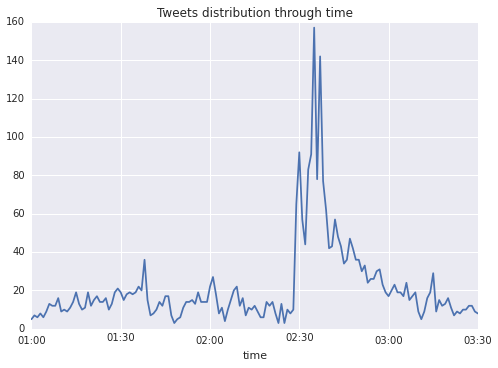

In [283]:
df = tweets.groupby(['time']).size().plot(title="Tweets distribution through time")


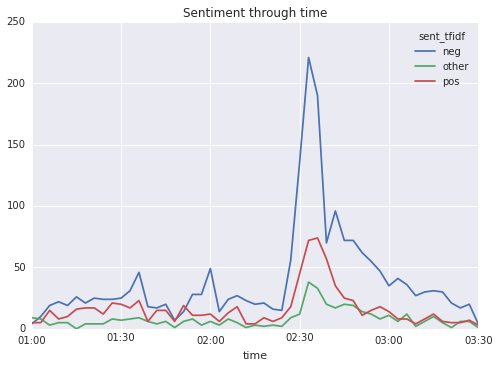

In [284]:
df = tweets.groupby(['time','sent_tfidf']).size().unstack().fillna(0)
df.groupby(pd.TimeGrouper('3Min')).sum().plot(title="Sentiment through time")

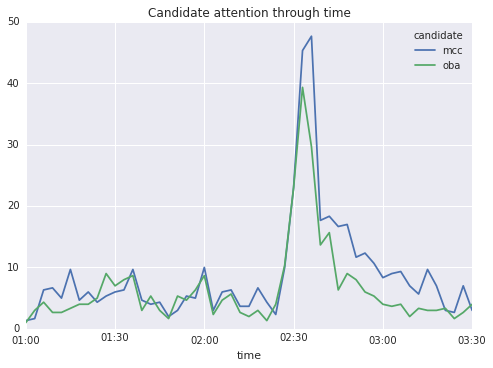

In [285]:
df = tweets[tweets["candidate"].str.contains('oba|mcc')].groupby(['time','candidate']).size().unstack().fillna(0)
df.groupby(pd.TimeGrouper('3Min')).mean().plot(title="Candidate attention through time")

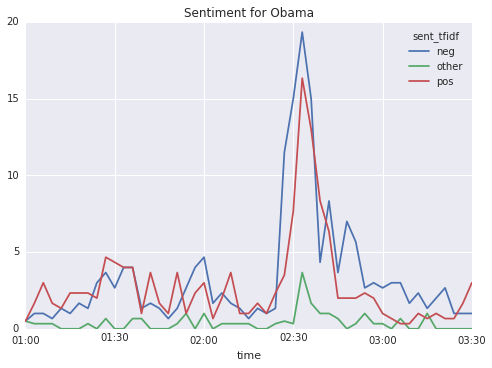

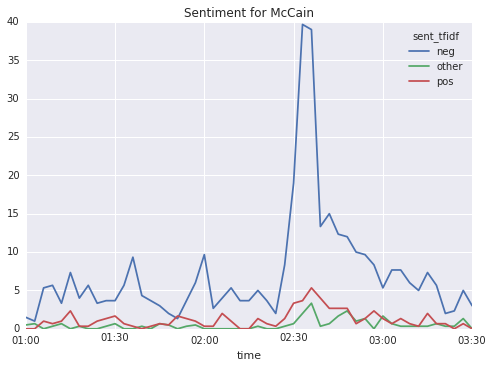

In [286]:
df = tweets[tweets["candidate"] == 'oba'].groupby(['time','sent_tfidf']).size().unstack().fillna(0)
df.groupby(pd.TimeGrouper('3Min')).mean().plot(title="Sentiment for Obama")

df = tweets[tweets["candidate"] == 'mcc'].groupby(['time','sent_tfidf']).size().unstack().fillna(0)
df.groupby(pd.TimeGrouper('3Min')).mean().plot(title="Sentiment for McCain")

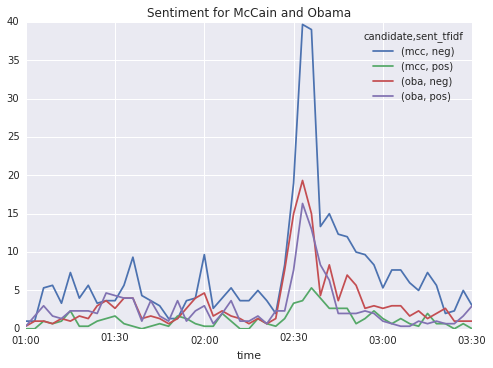

In [287]:
df = tweets[(tweets["candidate"].str.contains('oba|mcc')) & (tweets['sent_tfidf'] !='other')].groupby(['time','sent_tfidf', 'candidate']).size().unstack().unstack().fillna(0)
df.groupby(pd.TimeGrouper('3Min')).mean().plot(title="Sentiment for McCain and Obama")

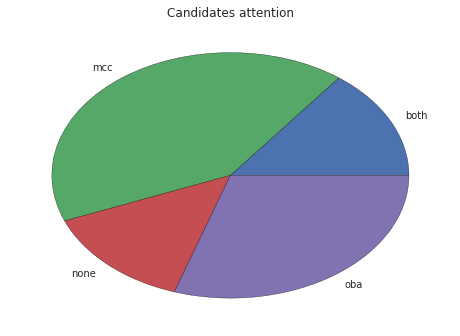

In [288]:
tweets.groupby(['candidate']).size().plot(kind='pie', title="Candidates attention")

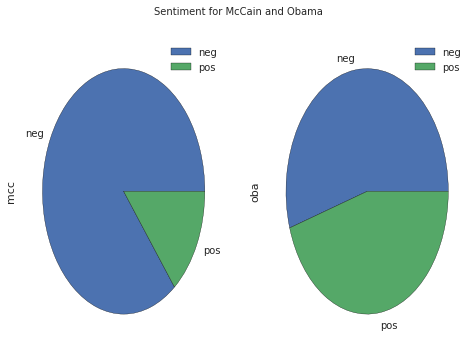

In [289]:
df = tweets[(tweets["candidate"].str.contains('oba|mcc')) & (tweets['sent_tfidf'] !='other')].groupby(['sent_tfidf', 'candidate']).size().unstack().fillna(0).plot(title="Sentiment for McCain and Obama", kind="pie", subplots="True")